In [ ]:
!pip install av

     |████████████████████████████████| 37.2MB 78kB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pylab as pl
from importlib import reload  

import sys
sys.path.append('/content/drive/My Drive/CA')
from scripts import *
from CAModel import *

In [3]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 5
N_ITERS = 50           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

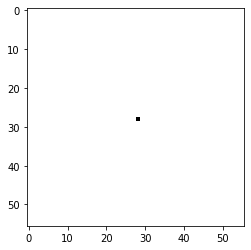

In [4]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

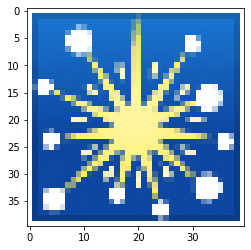

In [5]:
# Imports the target emoji
target = read_image("/content/drive/My Drive/CA/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [6]:
# Custom loss function
class loss_fn:
    """Custom l2 or l1 loss function"""
    def __init__(self, target, order=2):
        self.order = order
        self.target = target
        
    def __call__(self, x):
        return torch.mean(torch.abs(x[:, :4, :, :] - self.target)**self.order)

target = target.cpu()
loss_fn(Pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

tensor(0.2883)

In [7]:
class loss:

    def __init__(self, target, order=2):

        self.order = order
        self.target = target

    def __call__(self, x, batch_size=BATCH_SIZE):
  
        losses = torch.Tensor([torch.mean(torch.abs(x[i, :4, :, :] - self.target)**self.order) for i in range(batch_size)])
        loss = torch.mean(torch.abs(x[:, :4, :, :] - self.target)**self.order)

        return loss, losses

class Loss:

    def __init__(self, target, order=2):

        self.order = order
        self.target = target

    def __call__(self, x):
  
        losses = torch.mean(torch.abs(x[:, :4, :, :] - self.target)**self.order, [1,2,3])
        loss = torch.mean(losses)

        return loss, losses

def idx_max_loss(losses):

    return (losses == losses.max()).nonzero(as_tuple=True)[0][0].item()
    


In [8]:
target = target.cpu()
Loss(Pad(target, TARGET_PADDING), 1)(pool.sample(5)[0])

(tensor(0.2883), tensor([0.2883, 0.2883, 0.2883, 0.2883, 0.2883]))

In [9]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

target = target.to(device)
model = CAModel().to(device)
model2 = CellularAutomata().to(device)

In [ ]:
# loads a pretrained model
model.load("/content/drive/My Drive/CA/not_persistent.pt")

In [ ]:
# Make evolution video
model.makeVideo(video_size=IMAGE_SIZE, n_iters=N_ITERS*2, fps=10, rescaling=8)

In [9]:
# Train the model 1
optimizer = torch.optim.Adam(model.parameters())
criterion = loss_fn(Pad(target, TARGET_PADDING), order=1)
model.train()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000], gamma=0.2)
losses = []
for i in range(10000):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
    
    loss = criterion(inputs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

    if i % 100 == 0: print('it ',i,' loss ', loss.item())

NameError: ignored

In [10]:
# Train the model 2
optimizer = torch.optim.Adam(model.parameters())
criterion = Loss(Pad(target, TARGET_PADDING), order=1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000,40000], gamma=0.2)
model.train()
losses = []
for i in range(1000):

    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
    
    batch_avg_loss, batch_losses = criterion(inputs)
    batch_avg_loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(batch_avg_loss.item())

    inputs = inputs.to(cpu)
    # batch_losses = batch_losses.to(cpu)

    with torch.no_grad():
        if BATCH_SIZE > 1:
            where_max_loss = idx_max_loss(batch_losses)
            pool.update(MakeSeed(1, N_CHANNELS, IMAGE_SIZE), indexes[where_max_loss])
            pool.update(inputs[np.where(indexes!=indexes[where_max_loss])], np.where(indexes!=indexes[where_max_loss]))
        else:
            pool.update(inputs, indexes)

    if i % 100 == 0: print('it: ', i, ' --- ', 'batch avg loss: ', batch_avg_loss.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


it:  0  ---  batch avg loss:  0.28740644454956055
it:  100  ---  batch avg loss:  0.2133890688419342
it:  200  ---  batch avg loss:  0.1455100178718567
it:  300  ---  batch avg loss:  0.1222490444779396
it:  400  ---  batch avg loss:  0.1875063180923462
it:  500  ---  batch avg loss:  0.14142119884490967
it:  600  ---  batch avg loss:  0.1632678061723709
it:  700  ---  batch avg loss:  0.15191619098186493
it:  800  ---  batch avg loss:  0.1085096150636673
it:  900  ---  batch avg loss:  0.09966077655553818


In [9]:
def training(model, pool, optimizer, criterion, device, cpu, scheduler = None, n_epochs = 50000, evolution_iters = 50, **kwargs):

    model.train()

    losses = []

    for i in range(n_epochs):

        inputs, indexes = pool.sample(kwargs['batch_size'])
        inputs = inputs.to(device)
        optimizer.zero_grad()
        
        for j in range(evolution_iters+randint(-10, 10)):
            inputs = model(inputs)
        
        batch_avg_loss, batch_losses = criterion(inputs)
        batch_avg_loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(batch_avg_loss.item())

        inputs = inputs.to(cpu)
        # batch_losses = batch_losses.to(cpu)

        with torch.no_grad():
            if kwargs['batch_size'] > 1:
                where_max_loss = torch.argmax(batch_losses)
                pool.update(MakeSeed(1, kwargs['n_channels'], kwargs['image_size']), indexes[where_max_loss])
                pool.update(inputs[np.where(indexes!=indexes[where_max_loss])], np.where(indexes!=indexes[where_max_loss]))
            else:
                pool.update(inputs, indexes)

        if i % 100 == 0: print('epoch: ', i, ' --- ', 'batch avg loss: ', batch_avg_loss.item())

    return losses  

In [10]:
optimizer = torch.optim.Adam(model.parameters())
criterion = Loss(Pad(target, TARGET_PADDING), order=1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000,40000], gamma=0.2)
losses = training(model, pool, optimizer, criterion, device, cpu, scheduler=scheduler, n_epochs=5000, batch_size=BATCH_SIZE, n_channels=N_CHANNELS, image_size=IMAGE_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:  0  ---  batch avg loss:  0.2884247899055481
epoch:  100  ---  batch avg loss:  0.15481334924697876
epoch:  200  ---  batch avg loss:  0.13584855198860168
epoch:  300  ---  batch avg loss:  0.1184421107172966
epoch:  400  ---  batch avg loss:  0.3331870436668396
epoch:  500  ---  batch avg loss:  0.11000430583953857
epoch:  600  ---  batch avg loss:  0.11774124950170517
epoch:  700  ---  batch avg loss:  0.1420351266860962
epoch:  800  ---  batch avg loss:  0.10254082828760147
epoch:  900  ---  batch avg loss:  0.13251365721225739
epoch:  1000  ---  batch avg loss:  0.22007957100868225
epoch:  1100  ---  batch avg loss:  0.11515132337808609
epoch:  1200  ---  batch avg loss:  0.10833342373371124
epoch:  1300  ---  batch avg loss:  0.09854508936405182
epoch:  1400  ---  batch avg loss:  0.1501619964838028
epoch:  1500  ---  batch avg loss:  0.10780557245016098
epoch:  1600  ---  batch avg loss:  0.11756937950849533
epoch:  1700  ---  batch avg loss:  0.17609810829162598
epoch:  1

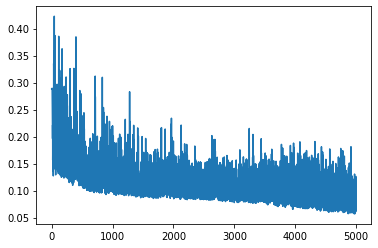

In [11]:
pl.plot(losses)

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

loss_avg = moving_average(np.array(losses), 500)

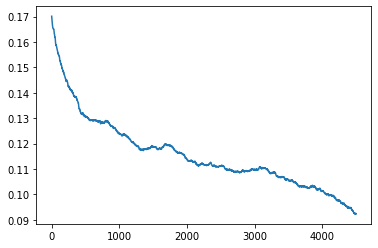

In [13]:
pl.plot(loss_avg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


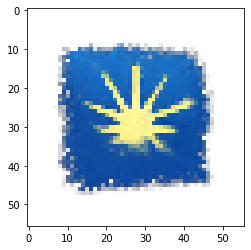

In [14]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

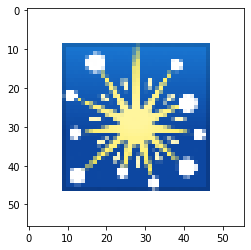

In [ ]:
# Plots the true emoji
imshow(Pad(target, TARGET_PADDING))

In [ ]:
# Make evolution video
model.makeVideo(video_size=IMAGE_SIZE, n_iters=N_ITERS*2, fname="video2_noprettrained.mkv", fps=10, rescaling=8)

In [10]:
optimizer = torch.optim.Adam(model.parameters())
criterion = Loss(Pad(target, TARGET_PADDING), order=1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000,40000], gamma=0.2)
losses = model2.to_train(pool, optimizer, criterion, device, cpu, scheduler=scheduler, n_epochs=5000, batch_size=BATCH_SIZE, n_channels=N_CHANNELS, image_size=IMAGE_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


it:  0  ---  batch avg loss:  0.2884247899055481
it:  100  ---  batch avg loss:  0.2884247899055481


KeyboardInterrupt: ignored

In [ ]:
datapool = Pool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
pooloader = DataLoader(datapool, batch_size=BATCH_SIZE, shuffle=True)
for inputs, indeces in pooloader:
  print(inputs.shape)

In [ ]:
image, _ = next(iter(pooloader))
imshow(image[0])

In [ ]:
# DATALOADER
target = target.cpu()
loss(Pad(target, TARGET_PADDING), 1)(next(iter(pooloader))[0])